# Introduction and Business Understanding

More and more electric vehicles can be seen on the streets as they are slowly replacing traditional vehicles with combustion engines. Electric vehicles can do without a fuel tank; instead they have a powerful battery which is used both for moving the vehicle as well as for powering other consumers, such as heating, airconditioning, multimedia, and infotainment. 

Most drivers of electric vehicles are well aware of the "State of Charge" that shows how much power is left in the battery throughout a trip. The fear of a breakdown due to an empty battery has even received its own terminology: "Range Anxiety". 

This Data Science project focusses on the "State of Charge" (SoC) of electric vehicles, explores dependencies to measures taken during a vehicle's trip, and makes predictions of the required battery power for a vehicle's trip. 

For the analysis, a dataset is used which includes 70 trips of a BMW i3 in 2019 in and around Munich, Germany. Throughout the trips a variety of measures have been recorded, such as velocity, acceleration, ambient temperature, elevation, heating, air conditioning, motor torque, and more.

## Structure of this Notebook

- Introduction and Business Understanding
- Importing Required Libraries
- Step 1 | Loading Data

# Importing Required Libraries

In [1]:
# Import libraries
import pandas as pd

from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

# Step 1 | Loading Data 

In [2]:
trips_df_by_seconds = pd.read_csv(filepath_or_buffer=('battery_and_heating_data/aggregated_trips/trips_df_by_seconds.csv'), 
                     sep=';', engine='python')


In [4]:
trips_df_by_seconds.drop(columns=['Unnamed: 0'], inplace=True)
trips_df_by_seconds.head()

,trip_id,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],...,Temperature Footweel Driver [Â°C],Temperature Footweel Co-Driver [Â°C],Temperature Feetvent Co-Driver [Â°C],Temperature Feetvent Driver [Â°C],Temperature Head Co-Driver [Â°C],Temperature Head Driver [Â°C],Temperature Vent Two [Â°C],Temperature Vent central right [Â°C],Temperature Vent central left [Â°C],Temperature Vent One [Â°C]
0,TripA01,0.0,0.000,574.0,0.000,0.050,-0.017,0.0,391.400,-2.291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TripA01,1.0,0.000,574.0,0.000,0.084,-0.013,0.0,391.363,-2.552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TripA01,2.0,0.000,574.0,8.770,7.655,0.036,0.0,391.283,-3.405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TripA01,3.0,0.869,574.0,16.683,45.279,0.404,0.0,391.124,-5.232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TripA01,4.0,2.251,574.0,13.427,25.005,0.162,0.0,391.196,-4.560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
def extract_and_sort_trip (local_trip_id):
    local_my_trip_sorted = trips_df_by_seconds[trips_df_by_seconds['trip_id'] == local_trip_id]
    local_my_trip_sorted = local_my_trip_sorted.sort_values(by='Time [s]').copy()
    return local_my_trip_sorted

In [144]:
def smooth_trip_velocity (local_my_trip_sorted, local_smoothing_range):
    local_my_trip_sorted['Smoothed Velocity'] = 0
    
    for i in np.array(local_my_trip_sorted['Time [s]'].unique()):
        local_my_trip_sorted.loc[local_my_trip_sorted['Time [s]'] == i, 
                                 'Smoothed Velocity'] = local_my_trip_sorted[(local_my_trip_sorted['Time [s]'] <= i) 
                                                                             & (my_trip_sorted['Time [s]'] > (i - smoothing_range))]['Velocity [km/h]'].mean()

    # Exclude stops from smoothing
    local_my_trip_sorted.loc[local_my_trip_sorted['Velocity [km/h]'] == 0, 'Smoothed Velocity'] = 0
    
    return local_my_trip_sorted

In [149]:
def split_trip_into_micro_fragments (local_my_trip_sorted, 
                                     stopped_duration, 
                                     cruising_duration, 
                                     cruising_threshold, 
                                     accelerating_duration, 
                                     accelerating_threshold,
                                     decelerating_duration, 
                                     decelerating_threshold):

    #stopped_duration = 3 #amount of time the vehicle has to remain unmoving for the micro fragment to be considered 'stopped'
    #cruising_duration = 10 
    #cruising_threshold = 5
    #accelerating_duration = 2
    #accelerating_threshold = 0.5 # km/h change per second
    #decelerating_duration = 2
    #decelerating_threshold = 0.25

    max_duration = np.max([stopped_duration, cruising_duration, accelerating_duration, decelerating_duration])
    local_my_trip_sorted['Micro Fragment'] = 'undefined'

    for i in np.array(local_my_trip_sorted['Time [s]'].unique()):
    
        #Get the velocities of the last 10 seconds
        last_velocities = np.array(local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] <= i) & 
                                                            (local_my_trip_sorted['Time [s]'] >= i-max_duration)]['Smoothed Velocity'])
    
        # Check if stopping criterion is met
        is_stopped = False
        if np.max(last_velocities[-stopped_duration:]) == 0:
            is_stopped = True
        if is_stopped: 
            local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] <= i) & (local_my_trip_sorted['Time [s]'] >= i-stopped_duration), 'Micro Fragment'] = 'stopped'
        
        # Check if cruising criterion is met
        is_cruising = False
        if abs(np.max(last_velocities[-cruising_duration:]) - np.min(last_velocities[-cruising_duration:])) < cruising_threshold:
            if last_velocities[len(last_velocities)-1] > 0:
                is_cruising = True            
        if is_cruising:
            local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] <= i) & (local_my_trip_sorted['Time [s]'] >= i-cruising_duration), 'Micro Fragment'] = 'cruising'
        
        # Check if accelerating criterion is met and if last velocities are continuously increasing (equal or more than previous)
        is_accelerating = False
        if len(last_velocities) >= accelerating_duration:
            if last_velocities[len(last_velocities)-1] - last_velocities[len(last_velocities)-accelerating_duration-1] >= accelerating_threshold * accelerating_duration:
                for v in range(1, len(last_velocities)):
                    if last_velocities[v] < last_velocities[v-1]:
                        is_accelerating = False
                        break
                    else:
                        is_accelerating = True        
        if is_accelerating:
            local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] <= i) & (local_my_trip_sorted['Time [s]'] > i-accelerating_duration), 'Micro Fragment'] = 'accelerating'

        # Check if decelerating criterion is met and if last velocities are continuously decreasing (equal or less than previous)
        is_decelerating = False
        if len(last_velocities) >= decelerating_duration:
            if last_velocities[len(last_velocities)-decelerating_duration-1] - last_velocities[len(last_velocities)-1] >= decelerating_threshold * decelerating_duration:
                for v in range(1, len(last_velocities)):
                    if last_velocities[v] > last_velocities[v-1]:
                        is_decelerating = False
                        break
                    else:
                        is_decelerating = True        
        if is_decelerating:
            local_my_trip_sorted.loc[(local_my_trip_sorted['Time [s]'] <= i) & (local_my_trip_sorted['Time [s]'] > i-decelerating_duration), 'Micro Fragment'] = 'decelerating'
    
    return local_my_trip_sorted

In [142]:
def plot_trip_micro_fragments(local_my_trip_sorted):
    # Setting plot parameters
    plt.rcParams['figure.figsize'] = [70, 10]
    f, (vel_ax, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

    # Plotting trip velocity
    vel_ax.plot(local_my_trip_sorted['Time [s]'], local_my_trip_sorted['Velocity [km/h]'], color = 'black')

    # Plotting micro fragments of the trip
    ax.plot(local_my_trip_sorted['Time [s]'], local_my_trip_sorted['Smoothed Velocity'], color = 'black')
    ax.fill_between(local_my_trip_sorted['Time [s]'], 0, 1, where= local_my_trip_sorted['Micro Fragment'] == 'stopped',
                    color='grey', alpha=0.5, transform=ax.get_xaxis_transform())

    ax.fill_between(local_my_trip_sorted['Time [s]'], 0, 1, where= local_my_trip_sorted['Micro Fragment'] == 'cruising',
                    color='blue', alpha=0.5, transform=ax.get_xaxis_transform())

    ax.fill_between(local_my_trip_sorted['Time [s]'], 0, 1, where= local_my_trip_sorted['Micro Fragment'] == 'accelerating',
                    color='red', alpha=0.5, transform=ax.get_xaxis_transform())
    
    ax.fill_between(local_my_trip_sorted['Time [s]'], 0, 1, where= local_my_trip_sorted['Micro Fragment'] == 'decelerating',
                    color='green', alpha=0.5, transform=ax.get_xaxis_transform())
            
    # Adding auxilliary plot segments
    f.suptitle(('Micro Fragments of ' + my_trip_sorted['trip_id'].unique()[0] + ' based on Smoothed Velocity in km/h over Time in Seconds'), fontsize=60)
    ax.text(0,-50,"■ Micro Fragment: Stopped", fontsize=40, color='grey')
    ax.text(0.25 * np.max(local_my_trip_sorted['Time [s]']),-50,"■ Micro Fragment: Cruising", fontsize=40, color='blue')
    ax.text(0.50 * np.max(local_my_trip_sorted['Time [s]']),-50,"■ Micro Fragment: Accelerating", fontsize=40, color='red')
    ax.text(0.75 * np.max(local_my_trip_sorted['Time [s]']),-50,"■ Micro Fragment: Decelerating", fontsize=40, color='green')
            
    plt.show() 

In [ ]:
my_trip_sorted = extract_and_sort_trip('TripA22')
my_trip_sorted = smooth_trip_velocity(my_trip_sorted, local_smoothing_range = 10)
my_trip_sorted = split_trip_into_micro_fragments(my_trip_sorted, 
                                                 stopped_duration = 3, 
                                                 cruising_duration = 10, 
                                                 cruising_threshold = 5, 
                                                 accelerating_duration = 2, 
                                                 accelerating_threshold = 0.5,
                                                 decelerating_duration = 2, 
                                                 decelerating_threshold = 0.25)
plot_trip_micro_fragments(my_trip_sorted)

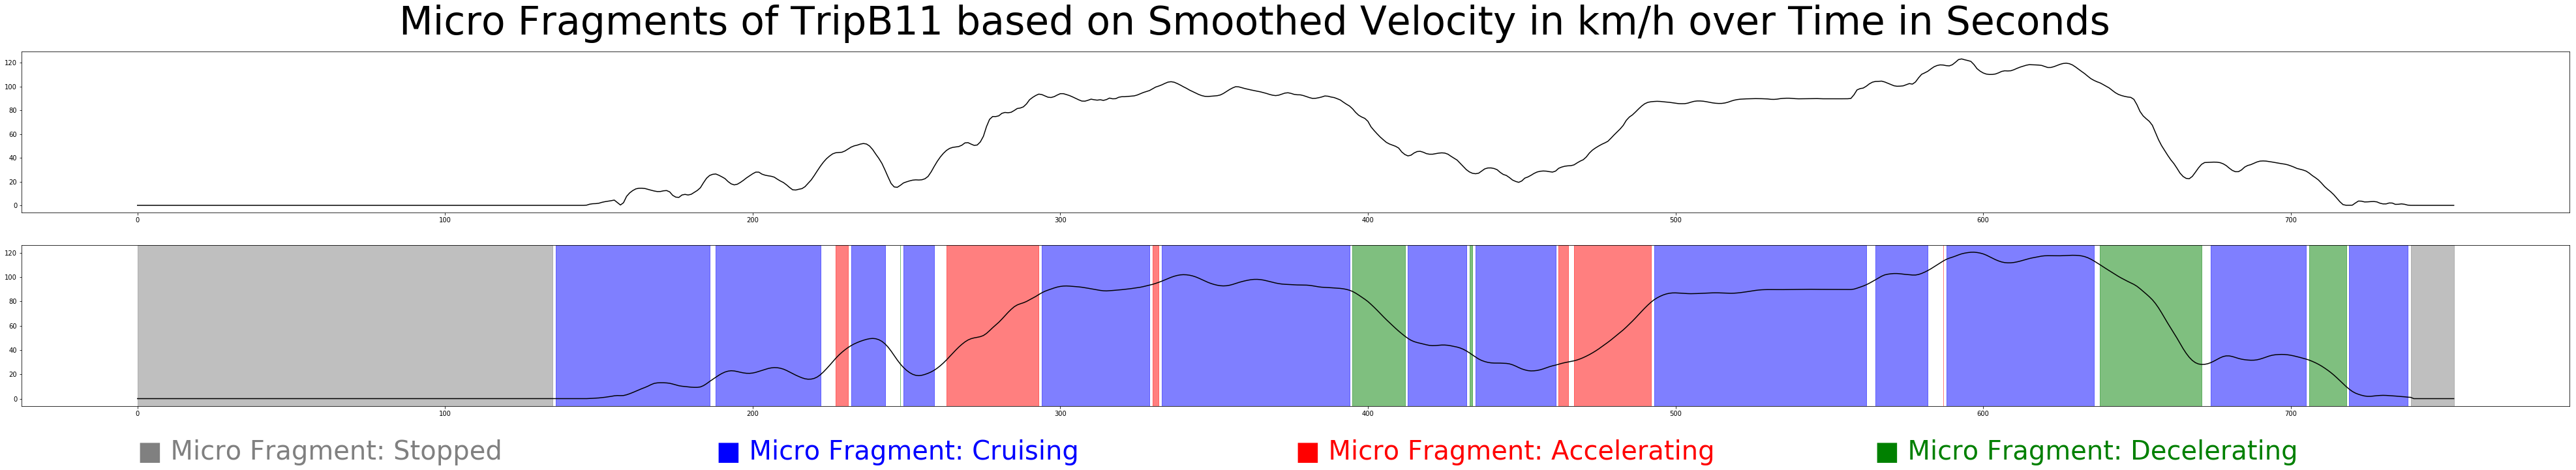

In [151]:
my_trip_sorted = extract_and_sort_trip('TripB11')
my_trip_sorted = smooth_trip_velocity(my_trip_sorted, local_smoothing_range = 10)
my_trip_sorted = split_trip_into_micro_fragments(my_trip_sorted, 
                                                 stopped_duration = 3, 
                                                 cruising_duration = 10, 
                                                 cruising_threshold = 5, 
                                                 accelerating_duration = 2, 
                                                 accelerating_threshold = 0.5,
                                                 decelerating_duration = 2, 
                                                 decelerating_threshold = 0.25)
plot_trip_micro_fragments(my_trip_sorted)

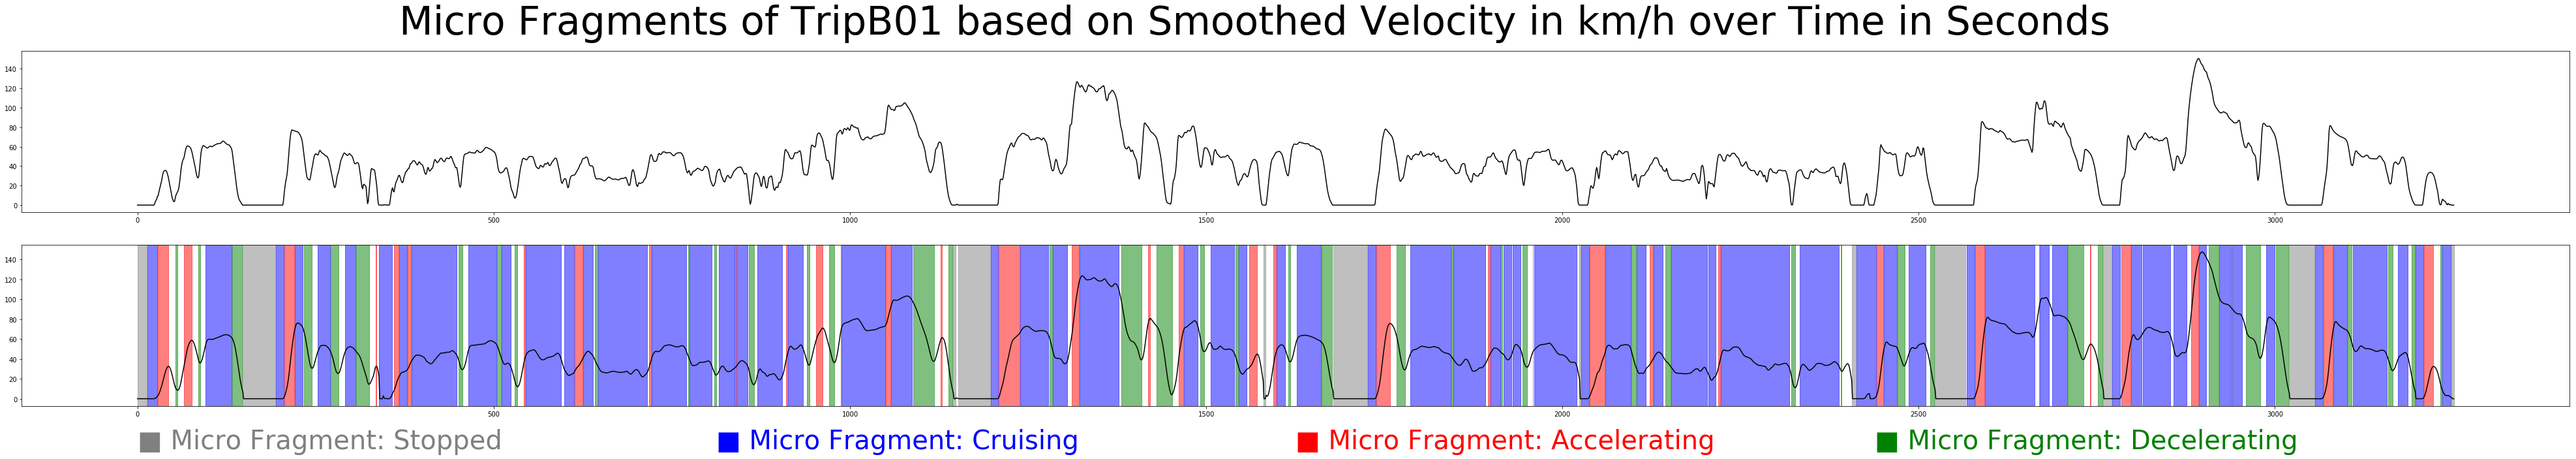

In [152]:
my_trip_sorted = extract_and_sort_trip('TripB01')
my_trip_sorted = smooth_trip_velocity(my_trip_sorted, local_smoothing_range = 10)
my_trip_sorted = split_trip_into_micro_fragments(my_trip_sorted, 
                                                 stopped_duration = 3, 
                                                 cruising_duration = 10, 
                                                 cruising_threshold = 5, 
                                                 accelerating_duration = 2, 
                                                 accelerating_threshold = 0.5,
                                                 decelerating_duration = 2, 
                                                 decelerating_threshold = 0.25)
plot_trip_micro_fragments(my_trip_sorted)

# Ideas for improving the trip split into micro fragments

In [15]:
# Micro Fragment 1: 'stopped'
## ToDo: how to handle brief stop interruptions, e.g. "roll forward" at a traffic light / intersection with less than X km/h

In [16]:
# Micro Fragment 2: 'cruising'
# To Check: can other factors be considered? Motor Torque, Elevation, Throttle below a certain percentage??

In [17]:
# Micro Fragment 3 and Micro Fragment 4: 'accelerating' and 'decelerating'
# To Check: can other factors be considered? Motor Torque, Throttle above a certain percentage, Acceleration, Braking??

# What Remains to be Said

The data used within this Notebook has been downloaded from Kaggle (https://www.kaggle.com/atechnohazard/battery-and-heating-data-in-real-driving-cycles). It has originally been published by Matthias Steinstraeter (Technical University of Munich, Institute of Automotive Technology), Johannes Buberger (Technical University of Munich, Institute of Automotive Technology), and Dimitar Trifonov (Technical University of Munich, Institute of Automotive Technology) in IEEE Data Portal (https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles).

Author of this Notebook is: F B

Created in March 2022